# 1. Setting up the Pyspark Environment

In [1]:
!apt-get update # Update apt-get repository.
!apt-get install openjdk-8-jdk-headless -qq > /dev/null # Install Java.
!wget -q http://archive.apache.org/dist/spark/spark-3.1.1/spark-3.1.1-bin-hadoop3.2.tgz # Download Apache Sparks.
!tar xf spark-3.1.1-bin-hadoop3.2.tgz # Unzip the tgz file.
!pip install -q findspark # Install findspark. Adds PySpark to the System path during runtime.

# Set environment variables
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.1.1-bin-hadoop3.2"

!ls

# Initialize findspark
import findspark
findspark.init()

Hit:1 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:2 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Hit:3 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:5 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Get:6 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Ign:7 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Hit:8 https://r2u.stat.illinois.edu/ubuntu jammy Release
Hit:9 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:11 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Fetched 257 kB in 2s (158 kB/s)
Reading package lists... Done
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to prov

# 2. Creating a Spark Session

In [2]:
# Create a PySpark session
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()
spark

# 3. Mounitng Google Drive and Loading the Data

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
df = spark.read.csv("/content/drive/MyDrive/Air_Quality_Index_Prediction/all_pollutant_data_2017_2021.csv", header=True, inferSchema=True)
df.printSchema()

root
 |-- state_code: integer (nullable = true)
 |-- county_code: integer (nullable = true)
 |-- site_number: integer (nullable = true)
 |-- parameter_code: integer (nullable = true)
 |-- poc: integer (nullable = true)
 |-- latitude: double (nullable = true)
 |-- longitude: double (nullable = true)
 |-- datum: string (nullable = true)
 |-- parameter: string (nullable = true)
 |-- sample_duration_code: string (nullable = true)
 |-- sample_duration: string (nullable = true)
 |-- pollutant_standard: string (nullable = true)
 |-- date_local: string (nullable = true)
 |-- units_of_measure: string (nullable = true)
 |-- event_type: string (nullable = true)
 |-- observation_count: integer (nullable = true)
 |-- observation_percent: double (nullable = true)
 |-- validity_indicator: string (nullable = true)
 |-- arithmetic_mean: double (nullable = true)
 |-- first_max_value: double (nullable = true)
 |-- first_max_hour: integer (nullable = true)
 |-- aqi: double (nullable = true)
 |-- method_co

In [5]:
df.show(5)

+----------+-----------+-----------+--------------+---+---------+----------+-----+---------------+--------------------+--------------------+------------------+----------+-----------------+----------+-----------------+-------------------+------------------+---------------+---------------+--------------+----+-----------+--------------------+---------------+-----------------+--------+------+-----+---------+--------------------+-------------------+
|state_code|county_code|site_number|parameter_code|poc| latitude| longitude|datum|      parameter|sample_duration_code|     sample_duration|pollutant_standard|date_local| units_of_measure|event_type|observation_count|observation_percent|validity_indicator|arithmetic_mean|first_max_value|first_max_hour| aqi|method_code|              method|local_site_name|     site_address|   state|county| city|cbsa_code|                cbsa|date_of_last_change|
+----------+-----------+-----------+--------------+---+---------+----------+-----+---------------+----

In [6]:
df.describe().show()

+-------+----------+------------------+------------------+------------------+------------------+------------------+-------------------+------+--------------+--------------------+--------------------+------------------+----------+--------------------+--------------------+------------------+-------------------+------------------+-----------------+------------------+------------------+------------------+------------------+--------------------+--------------------+--------------------+--------+------+-----------------+-----------------+--------------------+-------------------+
|summary|state_code|       county_code|       site_number|    parameter_code|               poc|          latitude|          longitude| datum|     parameter|sample_duration_code|     sample_duration|pollutant_standard|date_local|    units_of_measure|          event_type| observation_count|observation_percent|validity_indicator|  arithmetic_mean|   first_max_value|    first_max_hour|               aqi|       method_co

# Feature Engineering

# 4. Getting the Null Values of each Coloumn

In [7]:
from pyspark.sql import functions as F

# Count null values in each column
null_counts = df.select([F.count(F.when(F.col(c).isNull(), c)).alias(c) for c in df.columns])

# Show the result
null_counts.show()

+----------+-----------+-----------+--------------+---+--------+---------+-----+---------+--------------------+---------------+------------------+----------+----------------+----------+-----------------+-------------------+------------------+---------------+---------------+--------------+------+-----------+------+---------------+------------+-----+------+----+---------+------+-------------------+
|state_code|county_code|site_number|parameter_code|poc|latitude|longitude|datum|parameter|sample_duration_code|sample_duration|pollutant_standard|date_local|units_of_measure|event_type|observation_count|observation_percent|validity_indicator|arithmetic_mean|first_max_value|first_max_hour|   aqi|method_code|method|local_site_name|site_address|state|county|city|cbsa_code|  cbsa|date_of_last_change|
+----------+-----------+-----------+--------------+---+--------+---------+-----+---------+--------------------+---------------+------------------+----------+----------------+----------+---------------

## 5. Exploring each column

In [8]:
df.select('event_type').distinct().show()

+--------------------+
|          event_type|
+--------------------+
|     Events Included|
|           No Events|
|Concurred Events ...|
|     Events Excluded|
+--------------------+



In [9]:
df.select('datum').distinct().show()

+-----+
|datum|
+-----+
|NAD83|
|WGS84|
+-----+



In [10]:
df.select('cbsa').distinct().show(truncate=False)

+--------------------------+
|cbsa                      |
+--------------------------+
|Durango, CO               |
|null                      |
|Grand Junction, CO        |
|Glenwood Springs, CO      |
|Greeley, CO               |
|Montrose, CO              |
|Pueblo, CO                |
|Steamboat Springs, CO     |
|Craig, CO                 |
|Boulder, CO               |
|Ca¤on City, CO            |
|Denver-Aurora-Lakewood, CO|
|Colorado Springs, CO      |
|Fort Collins, CO          |
+--------------------------+



In [11]:
df.select('cbsa_code').distinct().show(truncate=False)

+---------+
|cbsa_code|
+---------+
|44460    |
|24540    |
|null     |
|14500    |
|19740    |
|18780    |
|24060    |
|24300    |
|20420    |
|33940    |
|22660    |
|17820    |
|39380    |
|15860    |
+---------+



In [12]:
df.select('first_max_value').distinct().count()

2972

In [13]:
df.select('pollutant_standard').distinct().show(truncate=False, n=1000)

+------------------+
|pollutant_standard|
+------------------+
|null              |
|NO2 Annual 1971   |
|PM25 24-hour 2012 |
|Ozone 8-Hour 1997 |
|SO2 1-hour 2010   |
|CO 1-hour 1971    |
|Ozone 1-hour 1979 |
|PM10 24-hour 2006 |
|PM25 24-hour 1997 |
|PM25 Annual 2012  |
|SO2 3-hour 1971   |
|SO2 24-hour 1971  |
|PM25 24-hour 2006 |
|NO2 1-hour 2010   |
|PM25 24-hour 2024 |
|PM25 Annual 1997  |
|Ozone 8-Hour 2008 |
|SO2 Annual 1971   |
|CO 8-hour 1971    |
|PM25 Annual 2006  |
|PM25 Annual 2024  |
|Ozone 8-hour 2015 |
+------------------+



## 6. Information about pollutants

7 Pollutants in total. Each codes corresponds to a pollutant -

1. Nitrogen dioxide (NO2) - 42602
2. Carbon monoxide (CO) - 42101
3. PM10 Total 0-10um STP - 81102
4. PM2.5 - Local Conditions - 88101
5. Benzene (C6H6) - 45201
6. Ozone (O3) - 44201
7. Sulfur dioxide (SO2) - 42401

In [14]:
from pyspark.sql.functions import when

df_pollutant_codes = df.select('parameter_code').distinct()
df_pollutant_codes = df_pollutant_codes.withColumnRenamed('parameter_code', 'pollutant_code')

df_pollutant_codes = df_pollutant_codes.withColumn(
    'pollutant_name',
    when(df_pollutant_codes.pollutant_code == 42602, 'Nitrogen dioxide (NO2)')
    .when(df_pollutant_codes.pollutant_code == 42101, 'Carbon monoxide (CO)')
    .when(df_pollutant_codes.pollutant_code == 81102, 'PM10 Total 0-10um STP')
    .when(df_pollutant_codes.pollutant_code == 88101, 'PM2.5 - Local Conditions')
    .when(df_pollutant_codes.pollutant_code == 45201, 'Benzene (C6H6)')
    .when(df_pollutant_codes.pollutant_code == 44201, 'Ozone (O3)')
    .when(df_pollutant_codes.pollutant_code == 42401, 'Sulfur dioxide (SO2)')
    .otherwise('Unknown')
)

df_pollutant_codes.show()

+--------------+--------------------+
|pollutant_code|      pollutant_name|
+--------------+--------------------+
|         42602|Nitrogen dioxide ...|
|         42101|Carbon monoxide (CO)|
|         81102|PM10 Total 0-10um...|
|         88101|PM2.5 - Local Con...|
|         45201|      Benzene (C6H6)|
|         44201|          Ozone (O3)|
|         42401|Sulfur dioxide (SO2)|
+--------------+--------------------+



In [15]:
grouped_df  = df.groupBy('site_number', 'parameter_code', 'date_local').count()
grouped_df.show()
num_of_rows = grouped_df.count()
num_of_rows

+-----------+--------------+----------+-----+
|site_number|parameter_code|date_local|count|
+-----------+--------------+----------+-----+
|       3001|         42101|2017-10-18|    2|
|          2|         42101|2017-04-07|    2|
|       1004|         42101|2017-12-15|    2|
|         18|         42101|2017-05-31|    2|
|         18|         42101|2017-10-03|    2|
|         18|         42101|2017-11-04|    2|
|       7001|         42101|2017-06-14|    2|
|       7001|         42101|2017-10-16|    2|
|         26|         42101|2017-06-13|    2|
|         26|         42101|2017-07-06|    2|
|         26|         42101|2017-10-22|    2|
|         26|         42101|2017-11-27|    2|
|         27|         42101|2017-12-16|    2|
|         27|         42101|2017-12-29|    2|
|          9|         42101|2017-01-03|    2|
|          2|         42401|2017-12-08|    4|
|         15|         42401|2017-03-08|    4|
|         15|         42401|2017-08-24|    4|
|         26|         42401|2017-0

133100

## 7. Filling in Null values in pollutant_standard for parameter benzene (Null Value Count: 50723)

In [16]:
# Checking if values gets filled for benzene parameter
df.na.fill("No Standard Available", "pollutant_standard").filter(df["parameter_code"] == 45201).show()

+----------+-----------+-----------+--------------+---+---------+----------+-----+---------+--------------------+---------------+--------------------+----------+--------------------+----------+-----------------+-------------------+------------------+---------------+---------------+--------------+----+-----------+--------------------+--------------------+-------------------+--------+------+--------------+---------+------------------+-------------------+
|state_code|county_code|site_number|parameter_code|poc| latitude| longitude|datum|parameter|sample_duration_code|sample_duration|  pollutant_standard|date_local|    units_of_measure|event_type|observation_count|observation_percent|validity_indicator|arithmetic_mean|first_max_value|first_max_hour| aqi|method_code|              method|     local_site_name|       site_address|   state|county|          city|cbsa_code|              cbsa|date_of_last_change|
+----------+-----------+-----------+--------------+---+---------+----------+-----+----

In [17]:
df = df.na.fill("No Standard Available", "pollutant_standard")

In [18]:
# Checking if values got filled for benzene parameter
df.filter(df["parameter_code"] == 45201).show()

+----------+-----------+-----------+--------------+---+---------+----------+-----+---------+--------------------+---------------+--------------------+----------+--------------------+----------+-----------------+-------------------+------------------+---------------+---------------+--------------+----+-----------+--------------------+--------------------+-------------------+--------+------+--------------+---------+------------------+-------------------+
|state_code|county_code|site_number|parameter_code|poc| latitude| longitude|datum|parameter|sample_duration_code|sample_duration|  pollutant_standard|date_local|    units_of_measure|event_type|observation_count|observation_percent|validity_indicator|arithmetic_mean|first_max_value|first_max_hour| aqi|method_code|              method|     local_site_name|       site_address|   state|county|          city|cbsa_code|              cbsa|date_of_last_change|
+----------+-----------+-----------+--------------+---+---------+----------+-----+----

## 8. Filling in Null values for cbsa and cbsa_code (Null Value Count: 116474 and 116474)

In [19]:
# Fill null values in cbsa and cbsa_code
df = df.withColumn("cbsa_code",
                           F.when(df["cbsa_code"].isNull(), 99999).otherwise(df["cbsa_code"])) \
               .withColumn("cbsa",
                           F.when(df["cbsa"].isNull(), "Non-CBSA Area").otherwise(df["cbsa"]))

# Show results
df.show(truncate=False)

+----------+-----------+-----------+--------------+---+---------+----------+-----+---------------+--------------------+---------------------+------------------+----------+-----------------+----------+-----------------+-------------------+------------------+---------------+---------------+--------------+----+-----------+-------------------------------------------------------------+---------------+-----------------+--------+------+-----+---------+--------------------------+-------------------+
|state_code|county_code|site_number|parameter_code|poc|latitude |longitude |datum|parameter      |sample_duration_code|sample_duration      |pollutant_standard|date_local|units_of_measure |event_type|observation_count|observation_percent|validity_indicator|arithmetic_mean|first_max_value|first_max_hour|aqi |method_code|method                                                       |local_site_name|site_address     |state   |county|city |cbsa_code|cbsa                      |date_of_last_change|
+-----

In [20]:
null_counts = df.select([F.count(F.when(F.col(c).isNull(), c)).alias(c) for c in df.columns])

null_counts.show()

+----------+-----------+-----------+--------------+---+--------+---------+-----+---------+--------------------+---------------+------------------+----------+----------------+----------+-----------------+-------------------+------------------+---------------+---------------+--------------+------+-----------+------+---------------+------------+-----+------+----+---------+----+-------------------+
|state_code|county_code|site_number|parameter_code|poc|latitude|longitude|datum|parameter|sample_duration_code|sample_duration|pollutant_standard|date_local|units_of_measure|event_type|observation_count|observation_percent|validity_indicator|arithmetic_mean|first_max_value|first_max_hour|   aqi|method_code|method|local_site_name|site_address|state|county|city|cbsa_code|cbsa|date_of_last_change|
+----------+-----------+-----------+--------------+---+--------+---------+-----+---------+--------------------+---------------+------------------+----------+----------------+----------+-----------------+-

## 9. Filling in Null values for local_site_name (Null Value Count: 33148)

In [21]:
df.select('local_site_name').distinct().show(truncate=False, n=1000)

+--------------------------------------------+
|local_site_name                             |
+--------------------------------------------+
|Silt-Collbran                               |
|Flattops #3                                 |
|McClure Pass                                |
|Greeley - Weld County Tower                 |
|DELTA HEALTH DEPT                           |
|Platteville - Middle School                 |
|Pawnee Buttes                               |
|I-25                                        |
|Grand Mesa                                  |
|MT CRESTED BUTTE REALTY BLDG                |
|Welby                                       |
|GRAND JUNCTION - POWELL BLDG                |
|Norwood                                     |
|Platteville Atmospheric Observatory         |
|Ripple Creek Pass                           |
|MANITOU SPRINGS                             |
|La Casa                                     |
|null                                        |
|Paradox     

In [22]:
from pyspark.sql.functions import col

df.filter(col("local_site_name").isNull()).show()

+----------+-----------+-----------+--------------+---+---------+-----------+-----+--------------+--------------------+---------------+------------------+----------+-----------------+----------+-----------------+-------------------+------------------+---------------+---------------+--------------+----+-----------+--------------------+---------------+--------------------+--------+---------+-------------+---------+-------------+-------------------+
|state_code|county_code|site_number|parameter_code|poc| latitude|  longitude|datum|     parameter|sample_duration_code|sample_duration|pollutant_standard|date_local| units_of_measure|event_type|observation_count|observation_percent|validity_indicator|arithmetic_mean|first_max_value|first_max_hour| aqi|method_code|              method|local_site_name|        site_address|   state|   county|         city|cbsa_code|         cbsa|date_of_last_change|
+----------+-----------+-----------+--------------+---+---------+-----------+-----+--------------+

In [23]:
df = df.na.fill("No Site Name Available", "local_site_name")

In [24]:
null_counts = df.select([F.count(F.when(F.col(c).isNull(), c)).alias(c) for c in df.columns])

null_counts.show()

+----------+-----------+-----------+--------------+---+--------+---------+-----+---------+--------------------+---------------+------------------+----------+----------------+----------+-----------------+-------------------+------------------+---------------+---------------+--------------+------+-----------+------+---------------+------------+-----+------+----+---------+----+-------------------+
|state_code|county_code|site_number|parameter_code|poc|latitude|longitude|datum|parameter|sample_duration_code|sample_duration|pollutant_standard|date_local|units_of_measure|event_type|observation_count|observation_percent|validity_indicator|arithmetic_mean|first_max_value|first_max_hour|   aqi|method_code|method|local_site_name|site_address|state|county|city|cbsa_code|cbsa|date_of_last_change|
+----------+-----------+-----------+--------------+---+--------+---------+-----+---------+--------------------+---------------+------------------+----------+----------------+----------+-----------------+-

## 10. Filling Null Values in method_code (Null Value Count: 6)

In [25]:
df.select('method_code').distinct().show(truncate=False, n=1000)

+-----------+
|method_code|
+-----------+
|126        |
|183        |
|236        |
|190        |
|599        |
|47         |
|null       |
|212        |
|54         |
|554        |
|127        |
|9          |
|100        |
|736        |
|87         |
|63         |
|143        |
|226        |
|195        |
|256        |
|200        |
|145        |
|574        |
|170        |
|204        |
|150        |
|600        |
|42         |
|79         |
|149        |
|99         |
|901        |
|74         |
+-----------+



In [26]:
df.select('method_code').distinct().count()

33

In [27]:
df.select('method').distinct().show(truncate=False, n=1000)

+---------------------------------------------------------------------------------------------------------------------+
|method                                                                                                               |
+---------------------------------------------------------------------------------------------------------------------+
|Teledyne Model 602 Beta plus w/VSCC - Beta Attenuation                                                               |
|R - P Co Partisol Model 2025 - Gravimetric                                                                           |
|Teledyne T640 at 5.0 LPM (Corrected) - Broadband spectroscopy                                                        |
|Instrumental - Ultra Violet 2B Model 202                                                                             |
|R & P Model 2000 PM-2.5 Air Sampler w/VSCC - Gravimetric                                                             |
|Instrumental - Chemiluminescence Thermo

In [28]:
df.select('method').distinct().count()

32

In [32]:
from pyspark.sql.functions import col

df.filter(col("method_code").isNull()).show()

+----------+-----------+-----------+--------------+---+---------+-----------+-----+---------+--------------------+--------------------+------------------+----------+-----------------+----------+-----------------+-------------------+------------------+---------------+---------------+--------------+----+-----------+------+--------------------+--------------------+--------+---------+-------------+---------+-------------+-------------------+
|state_code|county_code|site_number|parameter_code|poc| latitude|  longitude|datum|parameter|sample_duration_code|     sample_duration|pollutant_standard|date_local| units_of_measure|event_type|observation_count|observation_percent|validity_indicator|arithmetic_mean|first_max_value|first_max_hour| aqi|method_code|method|     local_site_name|        site_address|   state|   county|         city|cbsa_code|         cbsa|date_of_last_change|
+----------+-----------+-----------+--------------+---+---------+-----------+-----+---------+--------------------+--

In [35]:
from pyspark.sql import functions as F

# Use withColumn and when to fill null values in the 'method_code' column
df = df.withColumn(
    "method_code",
    F.when(F.col("method_code").isNull(), "not found").otherwise(F.col("method_code"))
)

+----------+-----------+-----------+--------------+---+---------+----------+-----+---------------+--------------------+--------------------+------------------+----------+-----------------+----------+-----------------+-------------------+------------------+---------------+---------------+--------------+----+-----------+--------------------+---------------+-----------------+--------+------+-----+---------+--------------------+-------------------+
|state_code|county_code|site_number|parameter_code|poc| latitude| longitude|datum|      parameter|sample_duration_code|     sample_duration|pollutant_standard|date_local| units_of_measure|event_type|observation_count|observation_percent|validity_indicator|arithmetic_mean|first_max_value|first_max_hour| aqi|method_code|              method|local_site_name|     site_address|   state|county| city|cbsa_code|                cbsa|date_of_last_change|
+----------+-----------+-----------+--------------+---+---------+----------+-----+---------------+----

In [36]:
null_counts = df.select([F.count(F.when(F.col(c).isNull(), c)).alias(c) for c in df.columns])
null_counts.show()

+----------+-----------+-----------+--------------+---+--------+---------+-----+---------+--------------------+---------------+------------------+----------+----------------+----------+-----------------+-------------------+------------------+---------------+---------------+--------------+------+-----------+------+---------------+------------+-----+------+----+---------+----+-------------------+
|state_code|county_code|site_number|parameter_code|poc|latitude|longitude|datum|parameter|sample_duration_code|sample_duration|pollutant_standard|date_local|units_of_measure|event_type|observation_count|observation_percent|validity_indicator|arithmetic_mean|first_max_value|first_max_hour|   aqi|method_code|method|local_site_name|site_address|state|county|city|cbsa_code|cbsa|date_of_last_change|
+----------+-----------+-----------+--------------+---+--------+---------+-----+---------+--------------------+---------------+------------------+----------+----------------+----------+-----------------+-

## 11. Filling Null Values in aqi (Null Value Count: 6)

In [37]:
from pyspark.sql import functions as F

mean_aqi = df.select(F.mean(F.col("aqi")).alias("mean_aqi")).collect()[0]["mean_aqi"]
df = df.withColumn(
    "aqi",
    F.when(F.col("aqi").isNull(), mean_aqi).otherwise(F.col("aqi"))
)

In [38]:
null_counts = df.select([F.count(F.when(F.col(c).isNull(), c)).alias(c) for c in df.columns])
null_counts.show()

+----------+-----------+-----------+--------------+---+--------+---------+-----+---------+--------------------+---------------+------------------+----------+----------------+----------+-----------------+-------------------+------------------+---------------+---------------+--------------+---+-----------+------+---------------+------------+-----+------+----+---------+----+-------------------+
|state_code|county_code|site_number|parameter_code|poc|latitude|longitude|datum|parameter|sample_duration_code|sample_duration|pollutant_standard|date_local|units_of_measure|event_type|observation_count|observation_percent|validity_indicator|arithmetic_mean|first_max_value|first_max_hour|aqi|method_code|method|local_site_name|site_address|state|county|city|cbsa_code|cbsa|date_of_last_change|
+----------+-----------+-----------+--------------+---+--------+---------+-----+---------+--------------------+---------------+------------------+----------+----------------+----------+-----------------+-------

### Now all null values are filled. we can start exploring the data now

# Data Exploration

In [45]:
from pyspark.sql.functions import col, count, mean, max, min, dayofmonth, hour
import matplotlib.pyplot as plt
import seaborn as sns

## 1. Distribution of Carbon Monoxide Levels

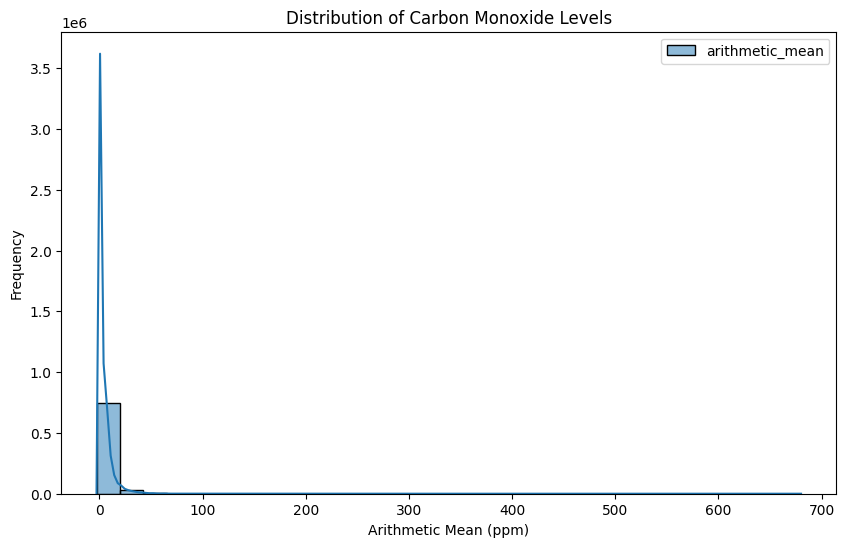

In [52]:
co_distribution = df.select("arithmetic_mean").toPandas()
plt.figure(figsize=(10, 6))
sns.histplot(co_distribution, bins=30, kde=True)
plt.title("Distribution of Carbon Monoxide Levels")
plt.xlabel("Arithmetic Mean (ppm)")
plt.ylabel("Frequency")
plt.show()

## 2. Average Carbon Monoxide Levels by County

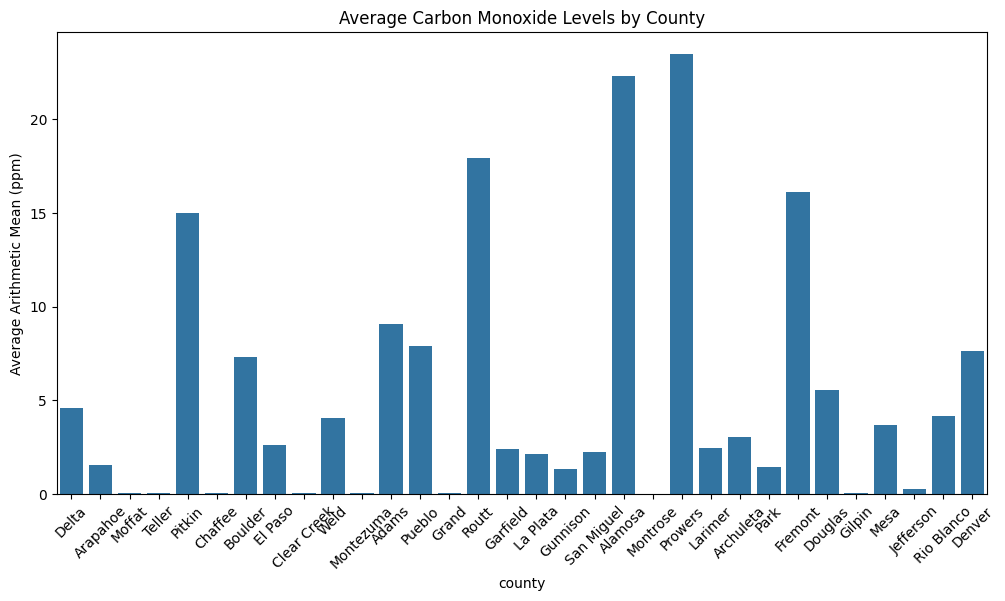

In [53]:
avg_co_by_county = df.groupBy("county").agg({"arithmetic_mean": "avg"}).toPandas()
plt.figure(figsize=(12, 6))
sns.barplot(data=avg_co_by_county, x="county", y="avg(arithmetic_mean)")
plt.title("Average Carbon Monoxide Levels by County")
plt.xticks(rotation=45)
plt.ylabel("Average Arithmetic Mean (ppm)")
plt.show()

## 3. Time Series of Carbon Monoxide Levels

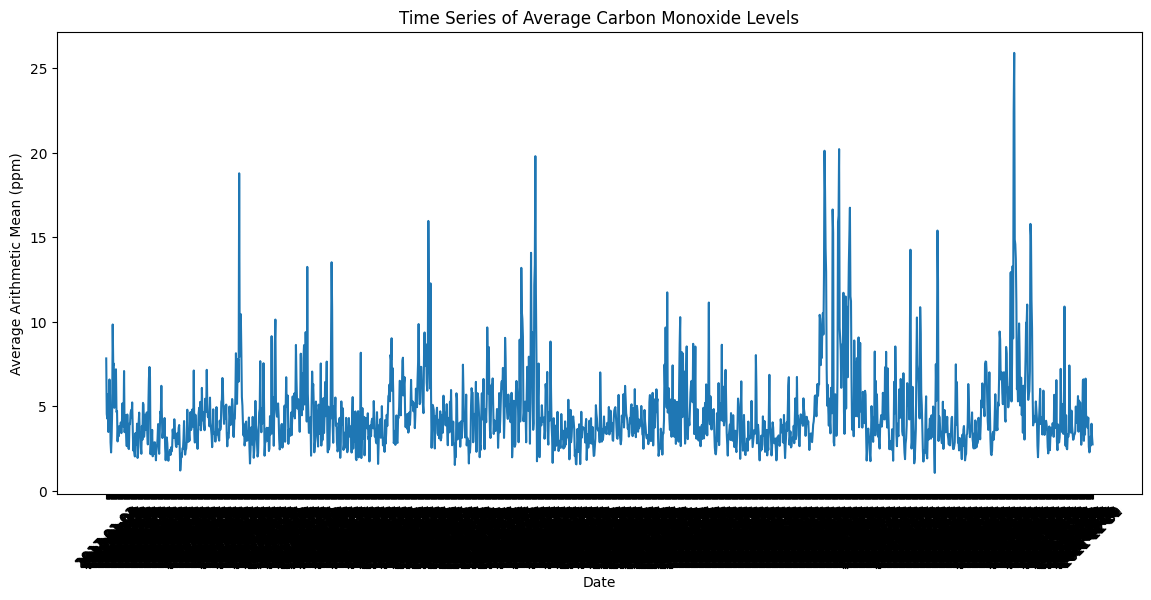

In [54]:
time_series_co = df.groupBy("date_local").agg({"arithmetic_mean": "avg"}).orderBy("date_local").toPandas()
plt.figure(figsize=(14, 6))
plt.plot(time_series_co['date_local'], time_series_co['avg(arithmetic_mean)'])
plt.title("Time Series of Average Carbon Monoxide Levels")
plt.xlabel("Date")
plt.ylabel("Average Arithmetic Mean (ppm)")
plt.xticks(rotation=45)
plt.show()

## 4. Maximum Carbon Monoxide Levels by Date

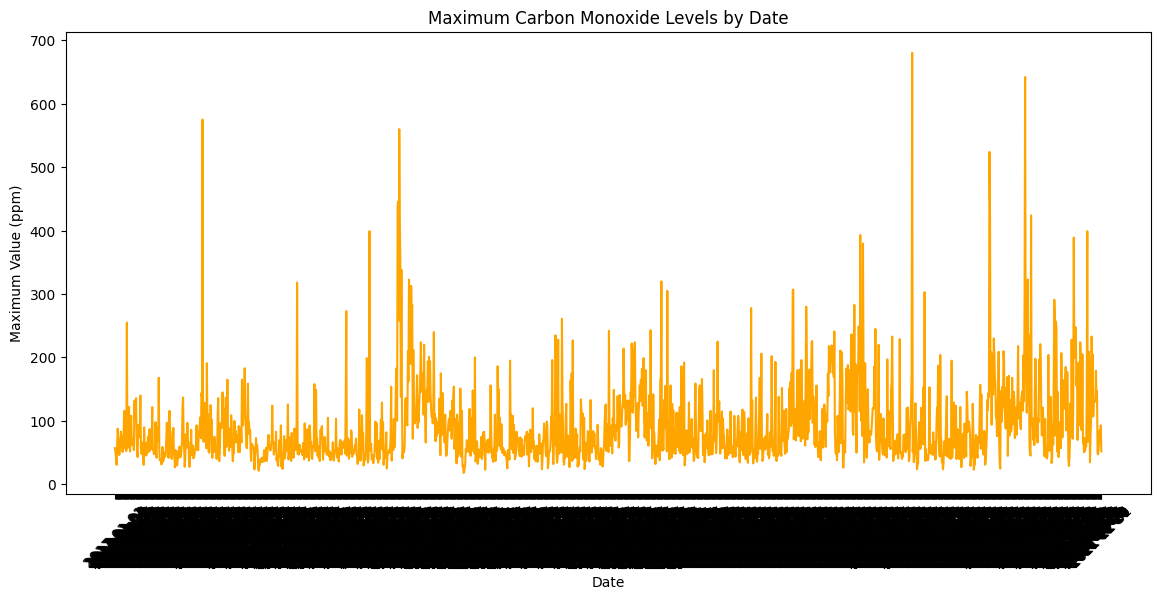

In [55]:
max_co_by_date = df.groupBy("date_local").agg({"first_max_value": "max"}).orderBy("date_local").toPandas()
plt.figure(figsize=(14, 6))
plt.plot(max_co_by_date['date_local'], max_co_by_date['max(first_max_value)'], color='orange')
plt.title("Maximum Carbon Monoxide Levels by Date")
plt.xlabel("Date")
plt.ylabel("Maximum Value (ppm)")
plt.xticks(rotation=45)
plt.show()

## 5. Average Carbon Monoxide Levels by Pollutant Standard

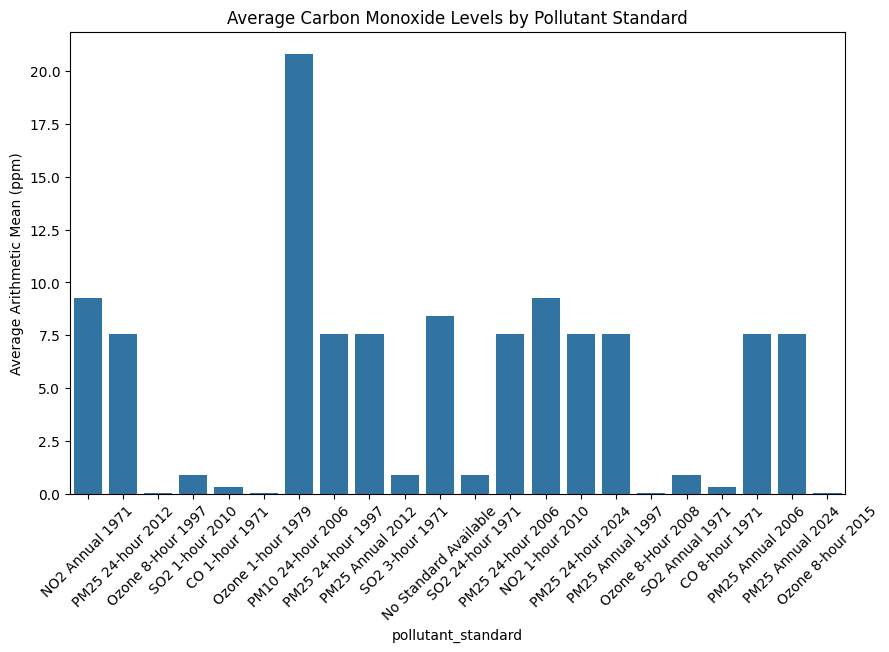

In [56]:
avg_co_by_standard = df.groupBy("pollutant_standard").agg({"arithmetic_mean": "avg"}).toPandas()
plt.figure(figsize=(10, 6))
sns.barplot(data=avg_co_by_standard, x="pollutant_standard", y="avg(arithmetic_mean)")
plt.title("Average Carbon Monoxide Levels by Pollutant Standard")
plt.ylabel("Average Arithmetic Mean (ppm)")
plt.xticks(rotation=45)
plt.show()

# 6. Count Plot of Air Quality Parameters

<ipython-input-66-ae239a257fde>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df.toPandas(), x='parameter', order=parameter_counts.index, palette='viridis')


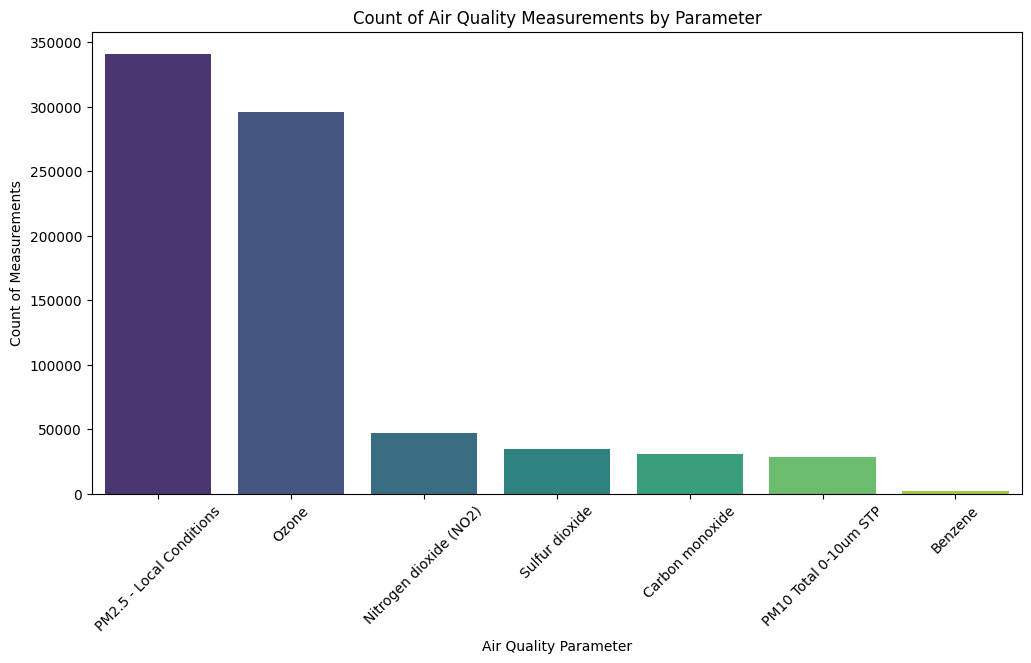

In [66]:
plt.figure(figsize=(12, 6))
# Convert the 'parameter' column to a Pandas Series and then apply value_counts()
parameter_counts = df.select('parameter').toPandas()['parameter'].value_counts()
sns.countplot(data=df.toPandas(), x='parameter', order=parameter_counts.index, palette='viridis')
plt.title("Count of Air Quality Measurements by Parameter")
plt.xlabel("Air Quality Parameter")
plt.ylabel("Count of Measurements")
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.show()

## 7. Boxplot of Carbon Monoxide Levels by Event Type

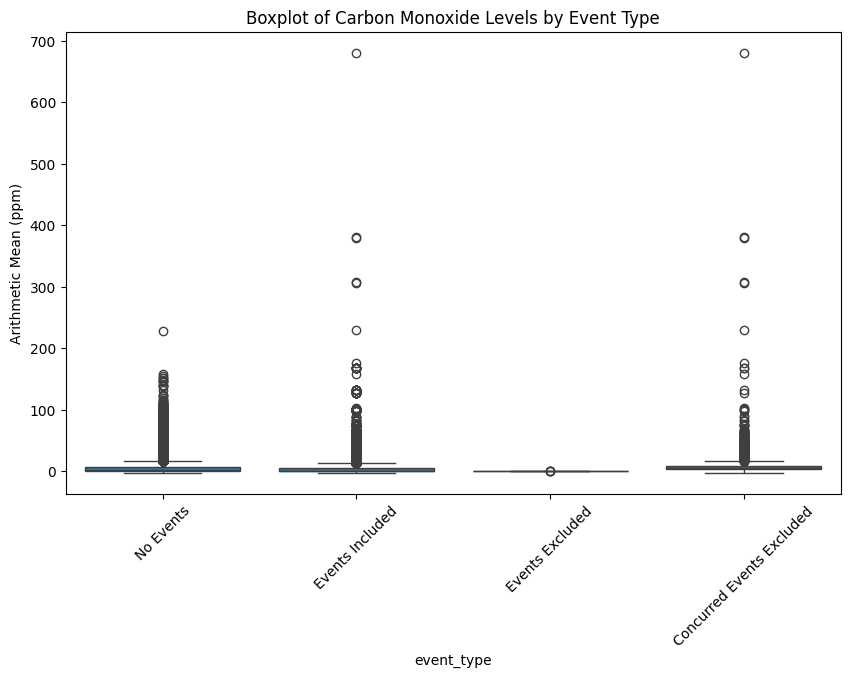

In [58]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df.toPandas(), x="event_type", y="arithmetic_mean")
plt.title("Boxplot of Carbon Monoxide Levels by Event Type")
plt.ylabel("Arithmetic Mean (ppm)")
plt.xticks(rotation=45)
plt.show()

## 8. Scatter Plot of First Max Value vs. Arithmetic Mean

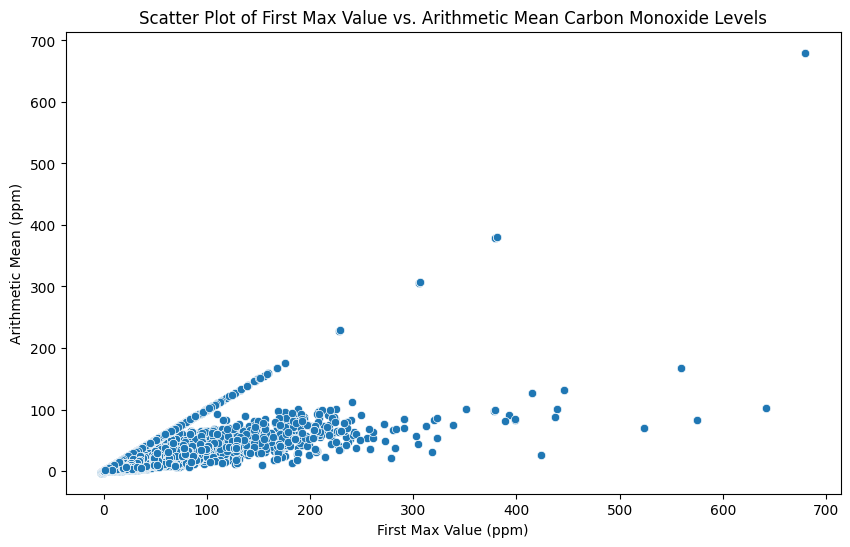

In [59]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df.toPandas(), x="first_max_value", y="arithmetic_mean")
plt.title("Scatter Plot of First Max Value vs. Arithmetic Mean Carbon Monoxide Levels")
plt.xlabel("First Max Value (ppm)")
plt.ylabel("Arithmetic Mean (ppm)")
plt.show()

## 9. Count of Observations by Event Type

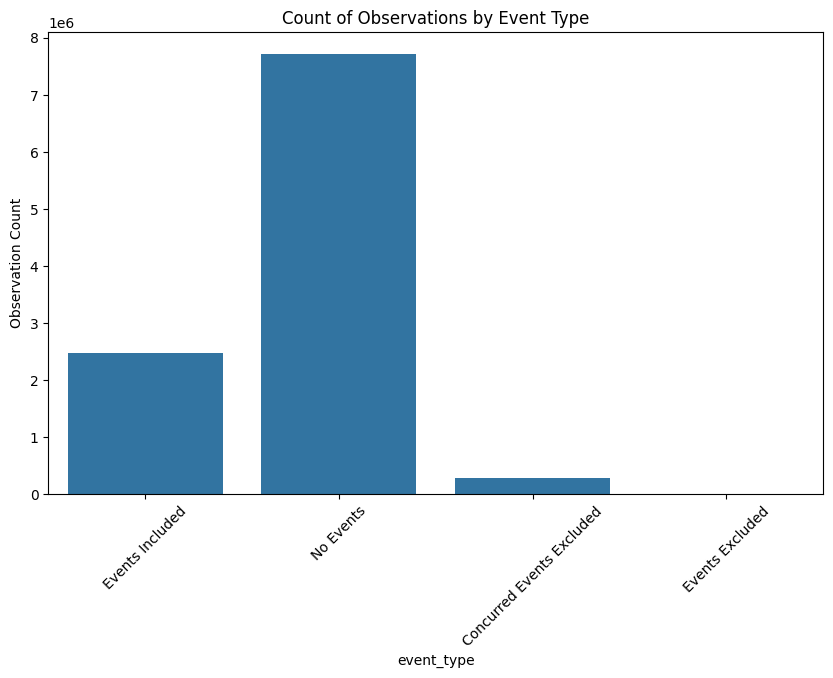

In [60]:
event_type_count = df.groupBy("event_type").agg({"observation_count": "sum"}).toPandas()
plt.figure(figsize=(10, 6))
sns.barplot(data=event_type_count, x="event_type", y="sum(observation_count)")
plt.title("Count of Observations by Event Type")
plt.ylabel("Observation Count")
plt.xticks(rotation=45)
plt.show()

## 10. AQI Levels Over Time

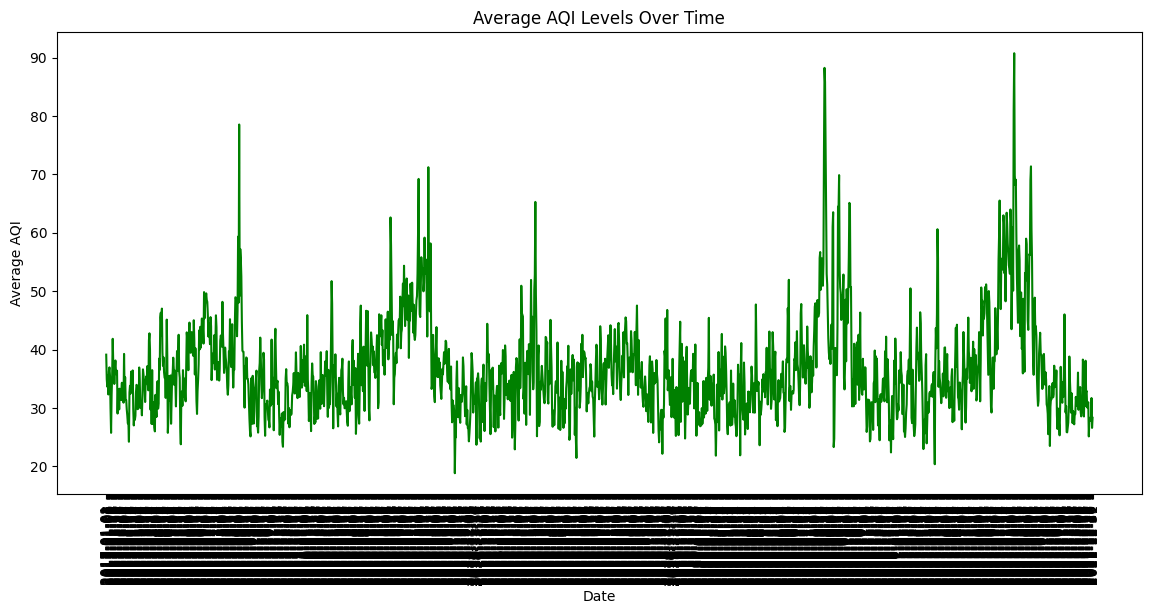

In [62]:
aqi_over_time = df.groupBy("date_local").agg({"aqi": "avg"}).orderBy("date_local").toPandas()
plt.figure(figsize=(14, 6))
plt.plot(aqi_over_time['date_local'], aqi_over_time['avg(aqi)'], color='green')
plt.title("Average AQI Levels Over Time")
plt.xlabel("Date")
plt.ylabel("Average AQI")
plt.xticks(rotation=90)
plt.show()